# Analiza prometnih nesreč v Sloveniji

In [144]:
import pandas as pd

years = range(2014, 2024)
dataFrames = []

for year in years:
    dataFrame = pd.read_csv(f"./data/pn{year}.csv", encoding="cp1250", delimiter=";")
    dataFrame["Year"] = year
    dataFrames.append(dataFrame)
    
#Vse v en dataframe (lažje iskanje)
data = pd.concat(dataFrames, ignore_index=True)

#Spremenimo , v . in kjer je NAN damo na 0
alko_raw = data["VrednostAlkotesta"].astype(str).str.replace(",", ".").str.strip()
alko = pd.to_numeric(alko_raw, errors="coerce").fillna(0)

## Klasifikacija nesreč

Na spodnjem stolpčnem diagramu smo prikazali število prometnih nesreč v Sloveniji v letu 2023, razvrščenih glede na njihovo klasifikacijo. Podatki so razdeljeni v več kategorij, med katerimi prevladujejo nesreče z materialno škodo.

Ta vrsta nesreče predstavlja daleč največji delež vseh obravnavanih primerov, kar kaže na to, da so najpogostejše situacije, kjer ne pride do telesnih poškodb, temveč zgolj do škode na vozilih ali infrastrukturi.

Alkohol


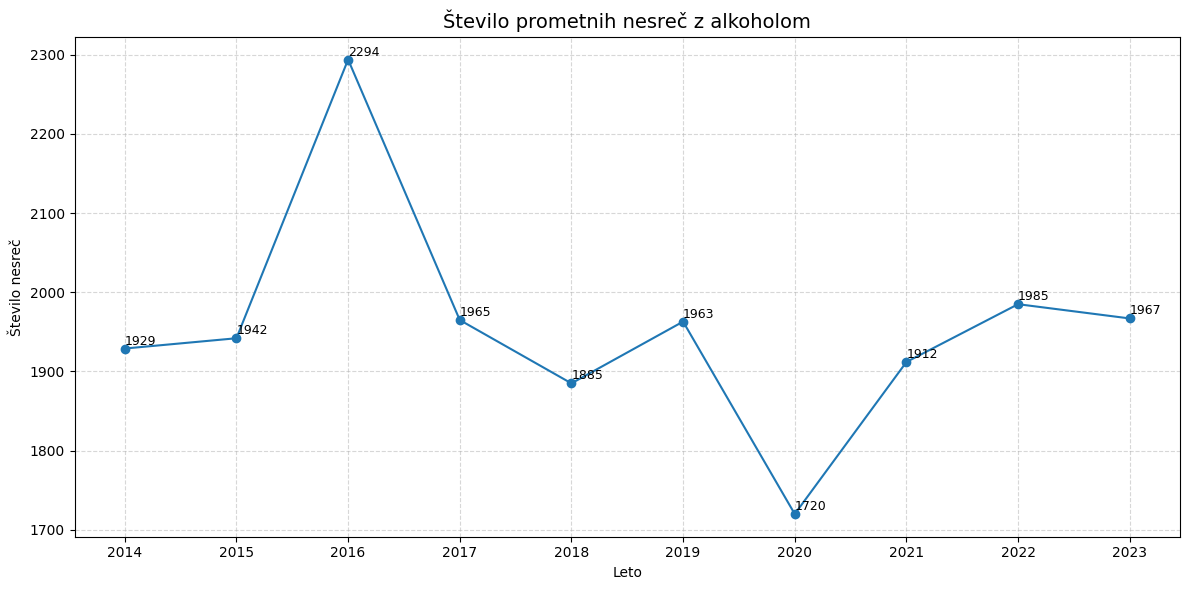

In [145]:
import matplotlib.pyplot as plt

alko_present = alko > 0
data["AlkoholPrisoten"] = alko_present

yearly_stats = data.groupby("Year").agg(
    Skupaj=("AlkoholPrisoten", "count"),
    ZAlkoholom=("AlkoholPrisoten", "sum")
)
yearly_stats["Odstotek"] = (yearly_stats["ZAlkoholom"] / yearly_stats["Skupaj"]) * 100

plt.figure(figsize=(12, 6))
plt.plot(yearly_stats.index, yearly_stats["ZAlkoholom"], marker="o")
for year, value in yearly_stats["ZAlkoholom"].items():
    plt.text(year, value + 5, value, fontsize=9)
plt.title("Število prometnih nesreč z alkoholom", fontsize=14)
plt.xlabel("Leto")
plt.ylabel("Število nesreč")
plt.xticks(yearly_stats.index)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


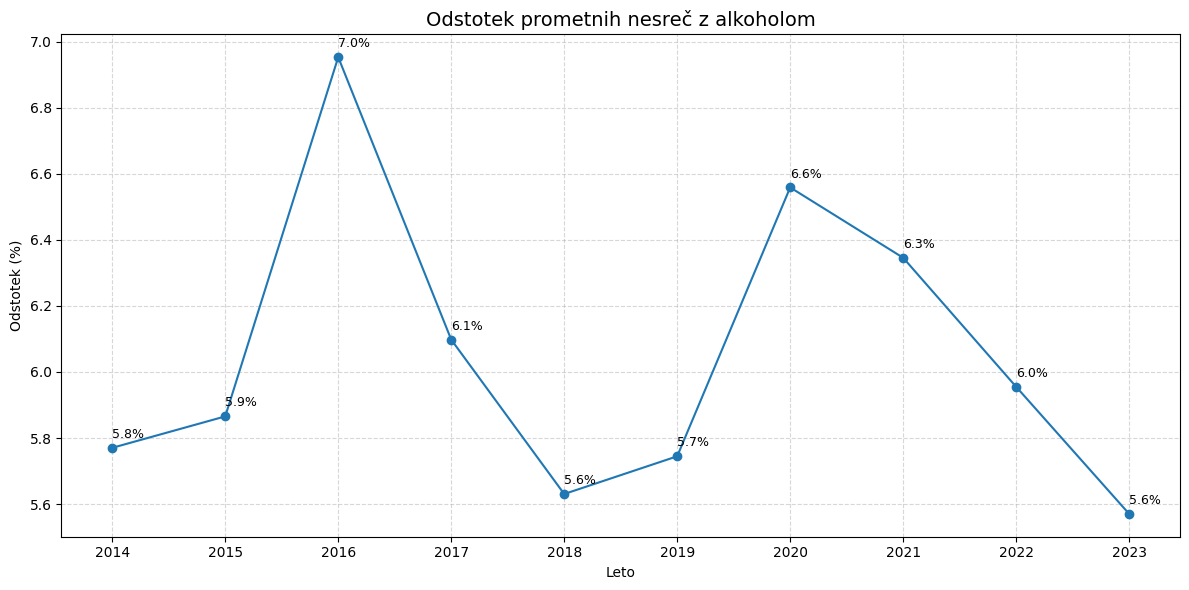

In [146]:
plt.figure(figsize=(12, 6))
plt.plot(yearly_stats.index, yearly_stats["Odstotek"], marker="o")
for year, value in yearly_stats["Odstotek"].items():
    plt.text(year, value + 0.03, f"{value:.1f}%", fontsize=9)
plt.title("Odstotek prometnih nesreč z alkoholom", fontsize=14)
plt.xlabel("Leto")
plt.ylabel("Odstotek (%)")
plt.xticks(yearly_stats.index)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

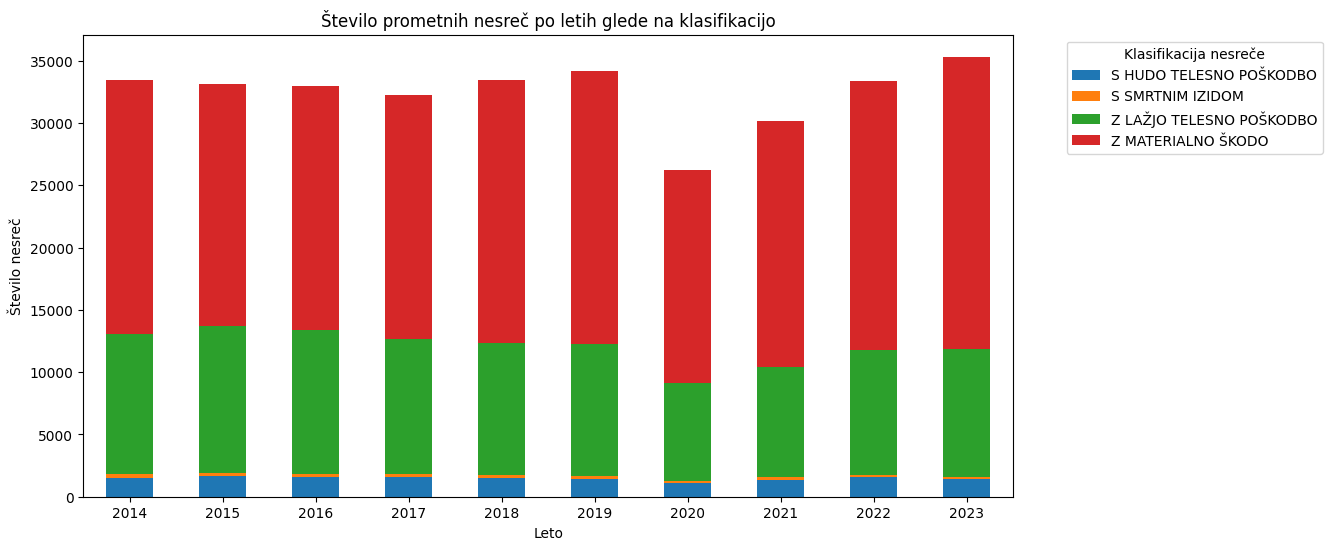

In [147]:
severity_by_year = data.groupby(["Year", "KlasifikacijaNesrece"]).size().unstack(fill_value=0)
severity_by_year = severity_by_year.sort_index()
severity_by_year.plot(
    kind='bar',
    stacked=True,
    figsize=(12,6)
)

plt.title("Število prometnih nesreč po letih glede na klasifikacijo")
plt.xlabel("Leto")
plt.ylabel("Število nesreč")
plt.legend(title="Klasifikacija nesreče", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.show()


VrstaUdelezenca  KOLESAR  PEŠEC  VOZNIK MOTORNEGA KOLESA
Year                                                    
2014                1414    679                      604
2015                1441    667                      689
2016                1394    714                      667
2017                1241    655                      757
2018                1269    616                      643
2019                1373    687                      701
2020                1372    457                      549
2021                1429    581                      637
2022                1528    624                      697
2023                1500    623                      715


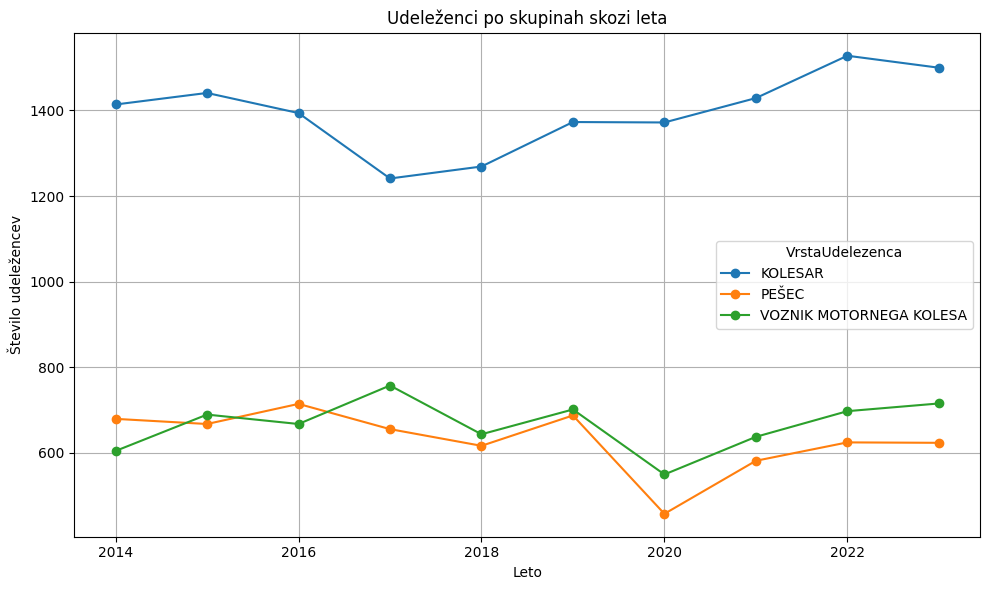

In [149]:
import matplotlib.pyplot as plt

ciljne_skupine = ["PEŠEC", "KOLESAR", "VOZNIK MOTORNEGA KOLESA"]

udelezenci_filtrirani = data[data["VrstaUdelezenca"].isin(ciljne_skupine)]

udelezenci_po_letih = (
    udelezenci_filtrirani
    .groupby(["Year", "VrstaUdelezenca"])
    .size()
    .unstack(fill_value=0)
)

print(udelezenci_po_letih)

# Narišemo črtni graf
udelezenci_po_letih.plot(kind="line", marker="o", figsize=(10, 6), title="Udeleženci po skupinah skozi leta")
plt.xlabel("Leto")
plt.ylabel("Število udeležencev")
plt.grid(True)
plt.tight_layout()
plt.show()


## Kolikšen delež povzročiteljev je imel pozitiven alkotest?

In [150]:
povzrocitelji = data[data["Povzrocitelj"] == "POVZROČITELJ"]

alko_raw = data["VrednostAlkotesta"].astype(str).str.replace(",", ".").str.strip()
alko = pd.to_numeric(alko_raw, errors="coerce").fillna(0)

pijani_povzrocitelji = povzrocitelji[alko.loc[povzrocitelji.index] > 0]
delež = len(pijani_povzrocitelji) / len(povzrocitelji)

print(f"Delež pijanih povzročiteljev: {delež:.2%}")


Delež pijanih povzročiteljev: 11.04%


## Histogram starosti povzročiteljev nesreč

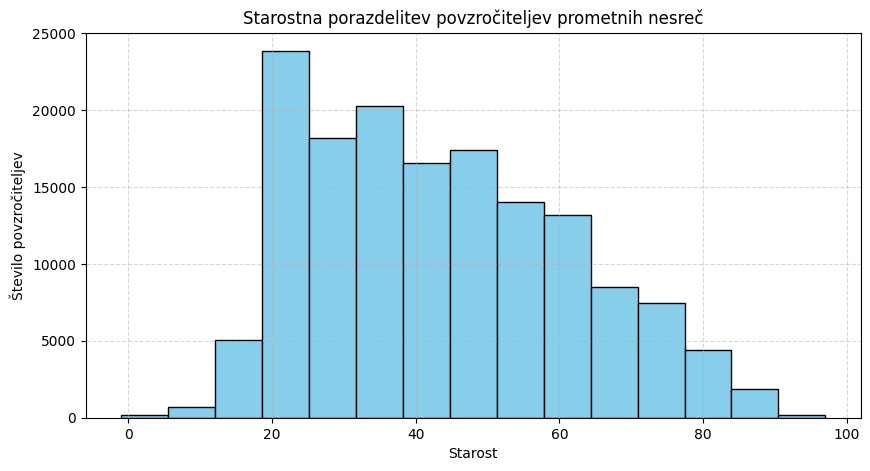

Povprečna starost povzročiteljev nesreč: 43.3 let


In [151]:
povzrocitelji = data[data["Povzrocitelj"] == "POVZROČITELJ"]

starosti = povzrocitelji["Starost"]

plt.figure(figsize=(10, 5))
plt.hist(starosti, bins=15, color="skyblue", edgecolor="black")
plt.title("Starostna porazdelitev povzročiteljev prometnih nesreč")
plt.xlabel("Starost")
plt.ylabel("Število povzročiteljev")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

povprecna_starost = starosti.mean()
print(f"Povprečna starost povzročiteljev nesreč: {povprecna_starost:.1f} let")



## Vizualizacija gručen udeležencev prometnih nesreč

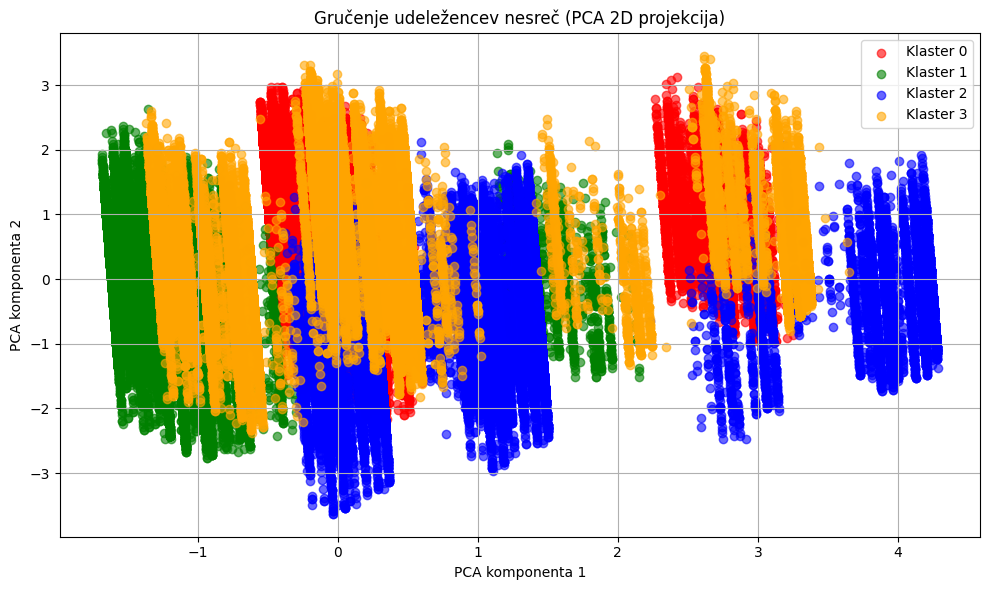

In [152]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

features = data[["Starost", "Spol", "AlkoholPrisoten", "VzrokNesrece", "TipNesrece"]].dropna()

label_cols = ["Spol", "VzrokNesrece", "TipNesrece"]
for col in label_cols:
    features[col] = LabelEncoder().fit_transform(features[col].astype(str))

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

pca = PCA(n_components=2)
reduced = pca.fit_transform(scaled_features)

df_plot = pd.DataFrame({
    "PCA1": reduced[:, 0],
    "PCA2": reduced[:, 1],
    "Cluster": clusters
})

colors = ["red", "green", "blue", "orange"]

plt.figure(figsize=(10, 6))
for cluster in sorted(df_plot["Cluster"].unique()):
    subset = df_plot[df_plot["Cluster"] == cluster]
    plt.scatter(subset["PCA1"], subset["PCA2"], c=colors[cluster], label=f"Klaster {cluster}", alpha=0.6)

plt.title("Gručenje udeležencev nesreč (PCA 2D projekcija)")
plt.xlabel("PCA komponenta 1")
plt.ylabel("PCA komponenta 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
